In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import RobustScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


* We have two data sources: Coinbase & Bitstamp, Coinbase data is more reliable

* On data cleaning
    * Step 1: change into 10 minutes features, set a number of function to apply on the groupby function to get features, set rules for 'nan' values(for example)
    * Step 2: building training & test samples
    * Step 3: Drop the samples with 10+missing value, the other missing values will be filled with 0
        * Note: When trading, output can be nan

In [2]:
data = pd.read_csv('../Data/ETH_1min.csv') ##Ethereum Historical Dataset
data['Unix Timestamp'] = data['Unix Timestamp'].astype(str).str[:10].astype(int) ## get the first 10 digits of timestamp for later transformation
data['Time'] = data['Unix Timestamp'].apply(dt.datetime.fromtimestamp)
data.set_index('Time', inplace=True)
data = data.sort_values(by='Time', ascending=True)
data = data[['Close', 'Volume']] ## select Close and Volume features
data.rename(columns = {'Close':"ETH Close",'Volume':'ETH Volume'}, inplace = True)

data2 = pd.read_csv('../Data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv')
data2['Time'] = data2['Timestamp'].apply(dt.datetime.fromtimestamp)
data2.set_index('Time', inplace=True)

data2['ETH_Close'] = data['ETH Close']
data2['ETH_Volume'] = data['ETH Volume']
data2 = data2[data2.index >= '2016-05-09 13:32:00']
data2

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,ETH_Close,ETH_Volume
Time,,,,,,,,,,
2016-05-09 13:32:00,1462800720,461.84,461.84,461.84,461.84,0.794450,366.908788,461.840000,12.00,4.156276
2016-05-09 13:33:00,1462800780,461.84,461.84,461.65,461.65,5.915210,2731.024202,461.695223,10.00,43.497506
2016-05-09 13:34:00,1462800840,461.68,461.83,461.68,461.83,0.995020,459.488841,461.788548,10.00,8.000000
2016-05-09 13:35:00,1462800900,461.78,461.78,461.77,461.77,0.639680,295.385891,461.771340,10.00,60.000000
2016-05-09 13:36:00,1462800960,461.77,461.77,461.77,461.77,3.819710,1763.827487,461.770000,10.00,0.375000
...,...,...,...,...,...,...,...,...,...,...
2019-01-07 22:02:00,1546898520,4006.01,4006.57,4006.00,4006.01,3.382954,13553.433078,4006.390309,150.55,0.022199
2019-01-07 22:03:00,1546898580,4006.01,4006.57,4006.00,4006.01,0.902164,3614.083169,4006.017233,149.57,500.000000
2019-01-07 22:04:00,1546898640,4006.01,4006.01,4006.00,4006.01,1.192123,4775.647308,4006.003635,150.48,201.784408


### Look at missing values
* Every day there are 24*60 = 1440 minutes
* Every feature will require 10 minutes data. Thus there'll be more missing values in features.

<AxesSubplot:title={'center':'Daily Number of Missing Values on coinbase data'}, xlabel='Time'>

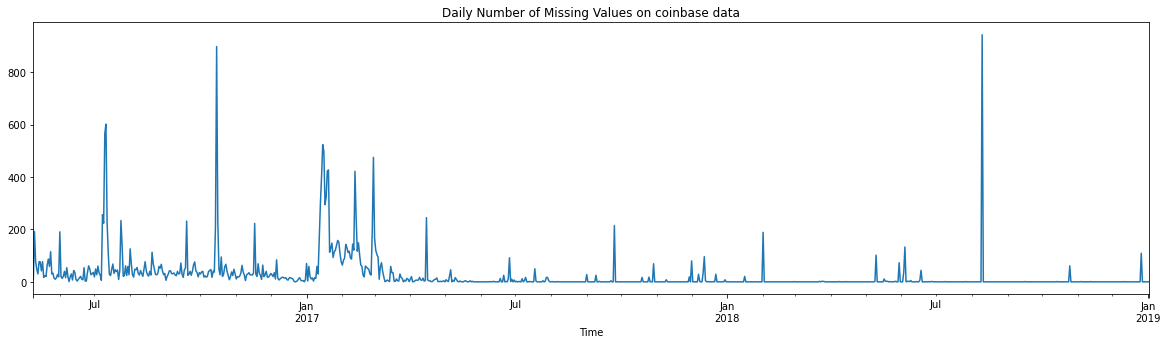

In [4]:
nandates2 = data2[np.isnan(data2['Open'])][['Open']]
nandates2['1'] = 1
counts2 = nandates2['1'].groupby(pd.Grouper(freq='d')).count()
counts2.plot(title='Daily Number of Missing Values on coinbase data', figsize=(20,5))

* Missing values appears occassionaly. At some days the whole day is missing

### Create features

* 10 min interval data(feature: 10min return, high-low, mean(abs(1min return)))

In [4]:
features = pd.DataFrame() # a df to collect 10-min features
windows = [] # we will drop the first max(windows) days
feature_names = []
df_gb = data2.groupby(pd.Grouper(freq='10min'))


## first feature: volume / past 1 days average 10min volume
feature = 'relative_vol'
feature_names.append(feature)

lookback = 1 * 24 * 6
windows.append(lookback)

vol = data2['Volume_(BTC)'].groupby(pd.Grouper(freq='10min')).sum() # 10-min volume
vol[vol==0] = np.nan
features[feature] = np.log(vol / vol.rolling(window=lookback).mean())


## second feature: return
feature = 'return'
feature_names.append(feature)

close = df_gb['Close'].apply(lambda x: x.iloc[-1])
features[feature] = np.log(close).diff() * 100  # log return


## third feature: high - low / mean(close)
feature = 'rela_HML'
feature_names.append(feature)

hml = df_gb.apply(lambda x: np.log((x['High'].max() - x['Low'].min()) / x['Close'].mean()))
hml[np.isinf(hml)] = np.nan
features[feature] = hml

## fourth feature: log realized volatility: mean(abs(return))
feature = 'Rvol'
feature_names.append(feature)

ret = np.abs(np.log(data2['Close']).diff())  # absolute log return every 1-min
rvol = np.log(ret.groupby(pd.Grouper(freq='10min')).sum()) 
rvol[np.isinf(rvol)] = np.nan
features[feature] = rvol

## fifth feature: Ethereum price / past 1 days average 10min price
feature = 'return_ETH'
feature_names.append(feature)

close = df_gb['ETH_Close'].apply(lambda x: x.iloc[-1]) # 10-min close
features[feature] = np.log(close).diff() * 100  # log return


## sixth feature: 10min均价 - 1h均价
feature = 'price_diff_1h'
feature_names.append(feature)

lookback = 6
windows.append(lookback)

ten_min_mean = data2['Close'].groupby(pd.Grouper(freq='10min')).mean() # 10-min volume
features[feature] = np.log(ten_min_mean / ten_min_mean.rolling(window=lookback).mean())

## seventh feature: 2h均价 - 12h均价
feature = 'price_diff_12h'
feature_names.append(feature)

lookback1 = 2 * 6
windows.append(lookback1)

lookback2 = 12 * 6
windows.append(lookback2)

features[feature] = np.log(ten_min_mean.rolling(window=lookback1).mean() / ten_min_mean.rolling(window=lookback2).mean())


features['Count'] = df_gb['Open'].count()
features[features['Count'] <= 6] = np.nan

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
features.to_csv('../Data/features.csv')
# features = pd.read_csv("../Data/features.csv", parse_dates=True, index_col=0)
# feature_names = features.columns[:-1]
features.describe()

,relative_vol,return,rela_HML,Rvol,return_ETH,price_diff_1h,price_diff_12h,Count
count,132836.000000,135614.000000,138291.000000,137914.000000,134783.000000,138174.000000,135577.000000,138336.000000
mean,-0.316171,0.001635,-6.359856,-5.951458,0.002627,0.000032,0.000396,9.906539
std,0.809736,0.415685,1.555816,1.506137,0.714612,0.004630,0.014469,0.396834
min,-5.261721,-24.562086,-14.484109,-14.064329,-36.155192,-0.130653,-0.138931,7.000000
25%,-0.826893,-0.097562,-6.969010,-6.574789,-0.101144,-0.001111,-0.003811,10.000000
50%,-0.312878,0.000838,-6.153982,-5.745641,0.000000,0.000093,0.000579,10.000000
75%,0.187318,0.110155,-5.418691,-5.002645,0.112631,0.001338,0.005736,10.000000
max,3.684879,13.341957,0.202231,2.294121,37.691321,0.073445,0.125890,10.000000


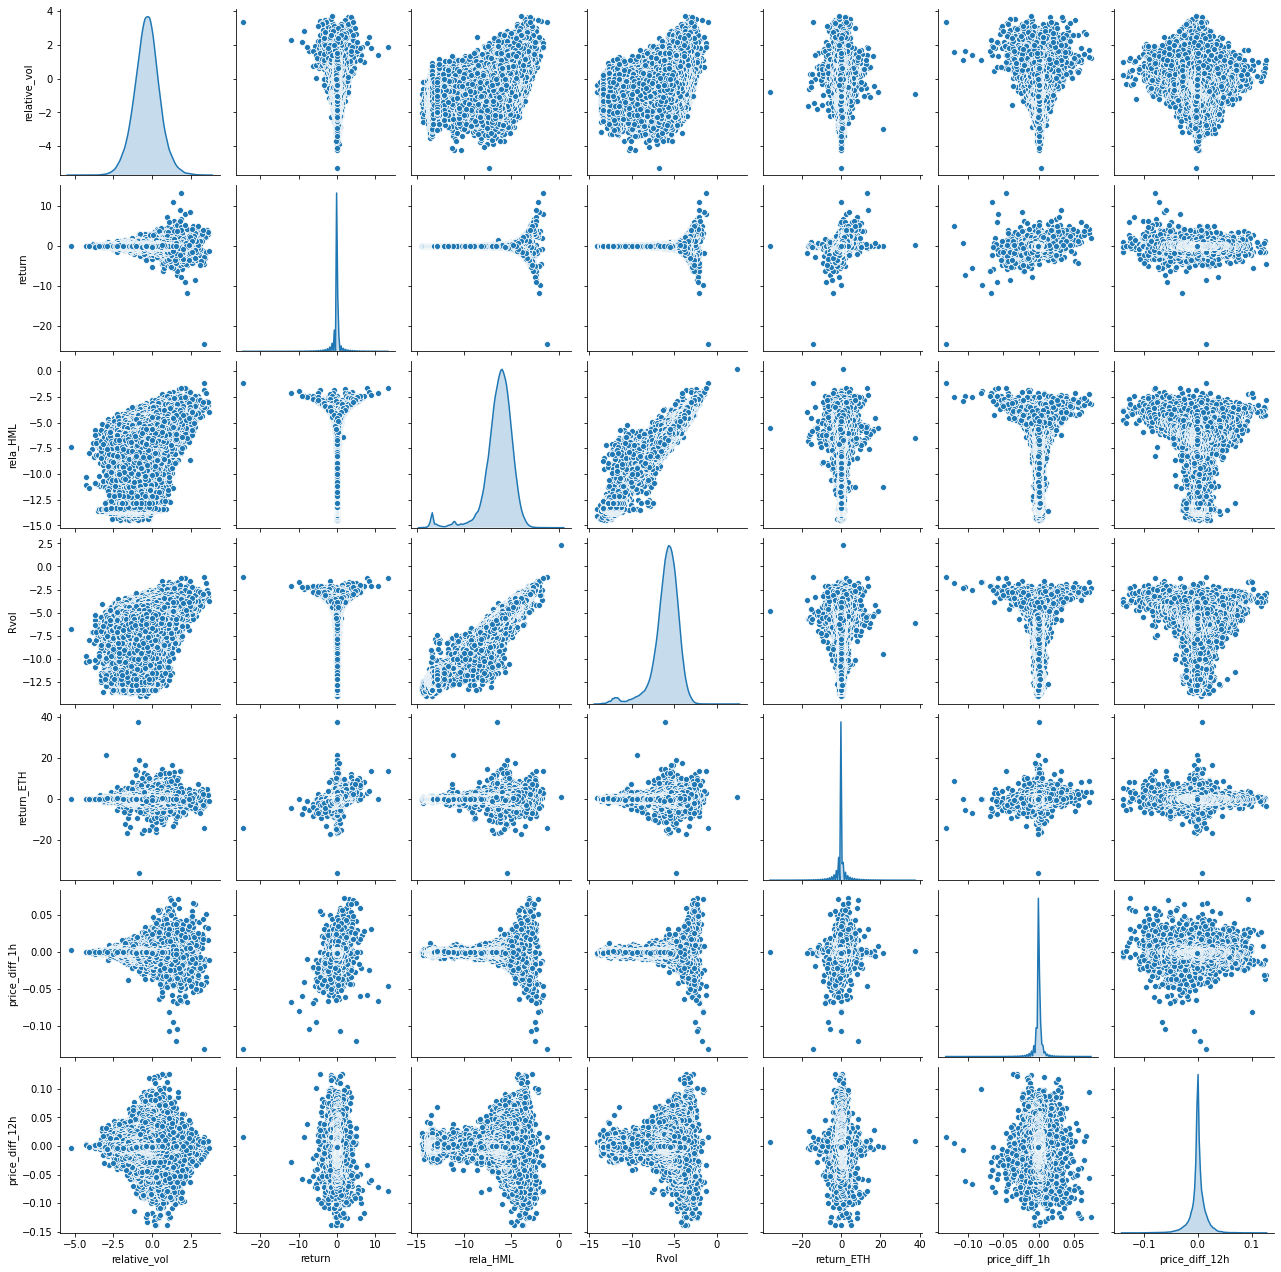

In [7]:
sns.pairplot(features[feature_names], diag_kind="kde")

* Normalize features:
    * rescale using robust scaler
    * clip the extremums
* Get labels:
    * 1 hour return
* Dropping missing values

* Train the model!!!

In [8]:
def normalize_features(feature, cliprange=3):
    """
    args:
        A pandas Series
    return:
        normalized feature, mean, scaler
    """
    scaler = RobustScaler()
    scaler.fit(feature.values.reshape(-1,1))
    feature = (feature-scaler.center_[0]) / scaler.scale_[0]
    feature[feature > cliprange] = cliprange
    feature[feature < -cliprange] = -cliprange
    return feature 

In [9]:
norm_features = features[feature_names].apply(normalize_features, axis=0, result_type='broadcast')
norm_features.describe()

,relative_vol,return,rela_HML,Rvol,return_ETH,price_diff_1h,price_diff_12h
count,132836.000000,135614.000000,138291.000000,137914.000000,134783.000000,138174.000000,135577.000000
mean,-0.003364,0.015862,-0.102364,-0.112137,0.009892,-0.001816,0.004200
std,0.797239,1.247281,0.886383,0.888377,1.457633,1.246449,1.225699
min,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
25%,-0.506812,-0.473720,-0.525717,-0.527399,-0.473135,-0.491519,-0.459808
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.493188,0.526280,0.474283,0.472601,0.526865,0.508481,0.540192
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


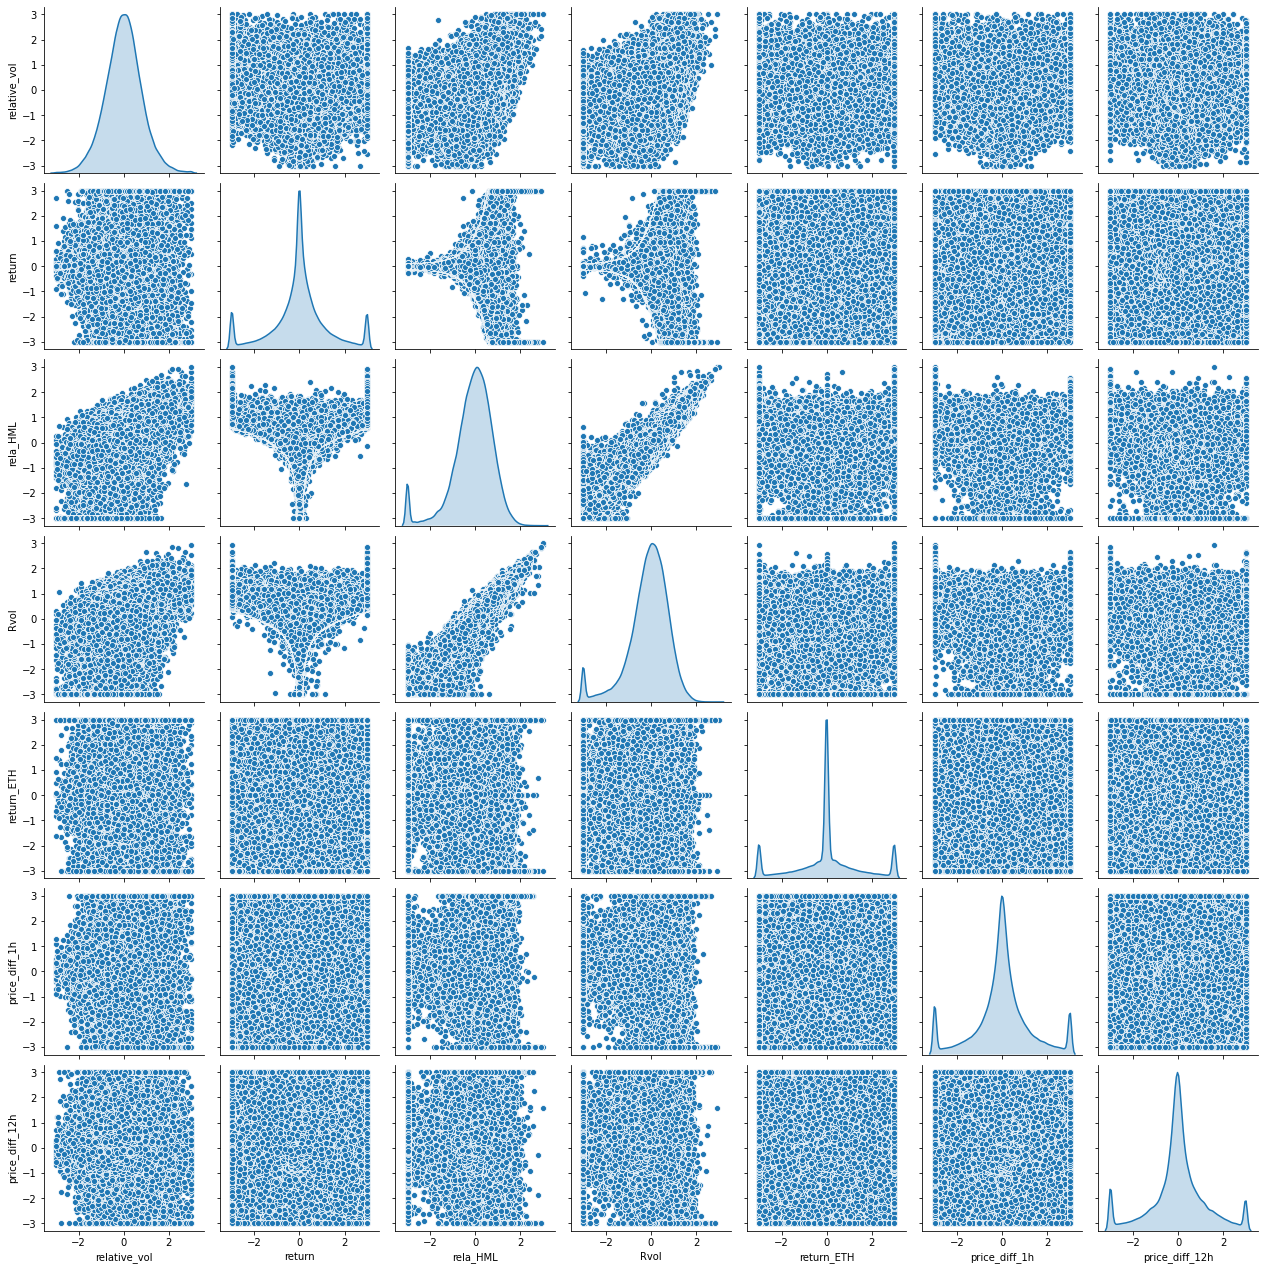

In [10]:
sns.pairplot(norm_features, diag_kind='kde')

* Note that features index are the bigining of the 10-minutes interval. Should be features.shift(1), so that index means the decision time.

In [17]:
norm_features = norm_features.shift(1)


* Get labels

In [11]:
close = data2.groupby(pd.Grouper(freq='10min')).apply(lambda x: x['Close'].iloc[-1])  # 10 minutes close price
ret_1h = np.log(close).diff(6) * 100

In [12]:
ret_10min = np.log(close).diff(1)
ret_10min.to_csv('ret_10min.csv')

In [13]:
ret_1h

Time
2016-05-09 13:30:00         NaN
2016-05-09 13:40:00         NaN
2016-05-09 13:50:00         NaN
2016-05-09 14:00:00         NaN
2016-05-09 14:10:00         NaN
                         ...   
2019-01-07 21:20:00   -0.218711
2019-01-07 21:30:00   -0.021177
2019-01-07 21:40:00    0.141083
2019-01-07 21:50:00   -0.003744
2019-01-07 22:00:00   -0.221921
Length: 140164, dtype: float64

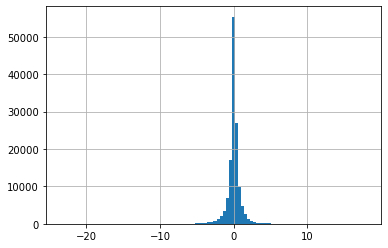

In [15]:
_=ret_1h.hist(bins=100)

 * Time t here pairs with the return between t+10min and t-50min. To make it the return 1 hour later from t, we should use ret_1h.shift(-5)

In [17]:
# Time t here pairs with the return between t+10min and t-50min. To make it the return 1 hour later from t, we should use ret_1h.shift(-5)
label = ret_1h.shift(-5)

In [34]:
## Save the norm_features and labels data
max_window = np.max(windows)
norm_features = norm_features.iloc[max_window:]
label = label.loc[norm_features.index]

norm_features.to_csv('norm_features.csv')
label.to_csv('label.csv')

### Dropping missing values
* For each sample, we have past 36 10-min intervals, thus in total 7*36 features. If there're more than 10 missing values (~4%), we drop this sample.
* The input & output file contains no missing values, flag_nan contains which samples are missing & which are kept. 

In [35]:
# Finding the nans

def nandetector(x, threshold=10):
    return np.sum(np.isnan(x)) > threshold  # true if there is more than 10 nan

def get_input_output(norm_features, label, window=36):
    shape = (len(label), window, norm_features.shape[1])
    input_data = np.zeros(shape)

    for t in range(window):
        input_data[:, t, :] = norm_features.shift(window-1 - t)
        
    flag_nan_input = np.zeros(len(input_data))
    for i in range(len(input_data)):
        flag_nan_input[i] = nandetector(input_data[i])    
    flag_nan_output = label.apply(np.isnan)

    flag_nan = (flag_nan_output.values + flag_nan_input).astype(bool)
    flag_nan = pd.Series(flag_nan, index=label.index)

    ## get inputs, outputs
    inputs = input_data[flag_nan.values==False]
    inputs[np.isnan(inputs)] = 0.0  

    outputs = label.values[flag_nan.values==False]
    
    return inputs, outputs, flag_nan

In [36]:
inputs, outputs, flag_nan = get_input_output(norm_features, label)

In [37]:
inputs.shape, outputs.shape

((119855, 36, 7), (119855,))

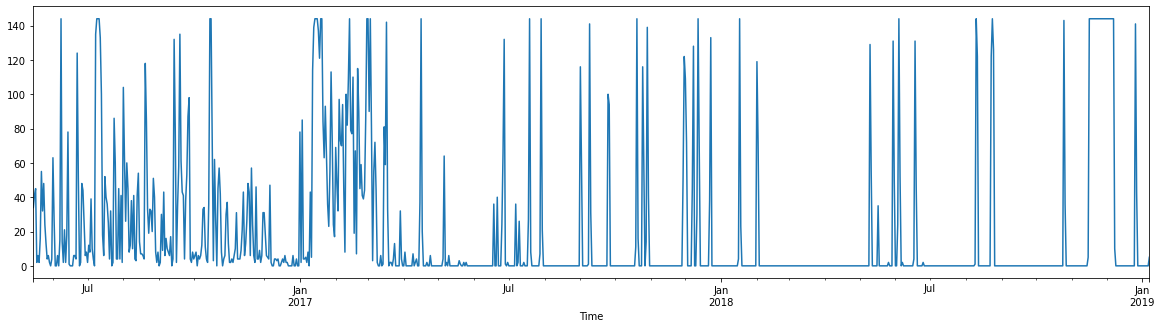

In [40]:
plt.figure(figsize=(20,5))
_ = flag_nan.groupby(pd.Grouper(freq='d')).sum().plot()

In [41]:
np.save('../Data/inputs', inputs)
np.save('../Data/outputs', outputs)